# This preprocessing workflow is developped at 08/07/2019
* mne event coding in VD {'12.0': 5, '100.0': 2, '21.0': 8, '102.0': 4, '254.0': 11, '131.0': 6, '132.0': 7, '1.0': 1, '23.0': 10, '101.0': 3, '255.0': 12, '22.0': 9})   6-safe period   7-threat period  11-start 12-end
* one needs to notice the event coding can be different in diff files
* event recoding three-number.0(float format) code: session+state+cond
    * section 1,2
    * state: VD:1, FA:2, OP:3
    * condition safe:1, threat:2  baseline:3




In [252]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR
===============================================
We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format 
Raw data with MNE package. We apply:
1) a notch filter to remove powerline artifact (50 Hz)
2) a 1Hz-100Hz band-pass filter
====> output = subj0*number*_*state*_filt_raw.fif  
Then concatenate the data of the same session
3) ASR and ICA fitting: This is a parallel process of preprocessing, 
    the goal is to store two sets of ica component images and generate an exclude dict from that: 
        3)do epochs in order to autoreject bad epochs and observe rejection report ===> output: cleaned epochs
        3)ICA fit and save the ICA components to reject - this is done by using function ica_component_selection()
        ====> output = fif file that save ica object and a rejecting component dict


Note: version not fullfill custer-run requirement

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from Autoreject_report_plot import Autoreject_report_plot #Gansheng
from utils_ASR import *
from scipy.linalg import toeplitz
from scipy import signal

%matplotlib qt
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'

########################################## Initialization parameter##########################################""
subj_list = ['94']
section_list=['1']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD','FA']
power_freq_array = [50]
reject_raw_data_section1 = {'07':['OP'],'10':['FA','VD'],'21':['VD'],'36':['OP']}
reject_raw_data_section2 = {'07':['OP'], '10':['VD'], '21':['FA','VD'],
                '22':['OP'], '57':['OP','FA'], '82':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channel={'94':{'FA1':['Pz']}}
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis


################################ step00: cut and filter data and concatenate 3 recording in one section ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    section2conctn_list=[]
    ############### single subject report ###########################
    rep = Report(image_format = 'png', subject = 'subj0'+subj)
    psd_figs=[]
    psd_captions=[]
    ASR_figs=[]
    ASR_captions=[]
    
    for section in section_list:
        reject_state=[]
        conctn_list = []
        conctn_anno_list=[]
#         conctn_dict = {}
        if subj in eval('reject_raw_data_section'+section).keys():
            reject_state = eval('reject_raw_data_section'+section)[subj]
            print("the rejected states of subject {} in section {} are {}".format(subj,section,reject_state))
        for state in state_list:
            if state in reject_state:
                continue
            else:
                raw_fname = raw_data_path + 'subj0'+subj+'_'+state+section+'_mast.set'
                raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')                
                events = mne.events_from_annotations(raw)
                events_coding=events[1]
                # take recording from 254 start of recording to 255 end of recording
                events=np.asarray(events[0])
                events_code_start = events_coding['254.0']
                events_code_end = events_coding['255.0']
                start = events[events[:,2]==events_code_start][0][0]
                stop = events[events[:,2]==events_code_end][0][0]
                raw_cut_filt = raw.copy()
                raw_cut_filt.crop(tmin = start/raw.info['sfreq'], tmax = stop/raw.info['sfreq'])
                raw_cut_filt.notch_filter(freqs=power_freq_array)
                raw_cut_filt.filter(l_freq=1,h_freq=100)
                
                psd_figs.append(raw_cut_filt.plot_psd())
                psd_captions.append('subject '+subj+"'s "+'psd plot after cut and filtering in section' 
                                    +section+ ' during '+state+' state')
                
                ############ annotation engineering ################
                index_dlt=0
                for i in range(raw_cut_filt.annotations.__len__()):
                    if (raw_cut_filt.annotations.__getitem__(i-index_dlt)['description']) not in ['131.0','132.0','255.0']:
                        raw_cut_filt.annotations.delete(i-index_dlt)
                        index_dlt+=1                       
                    else: 
                        continue
                mne_annotation_recode_by_adding(section=section,state=state,annotations=raw_cut_filt.annotations)

                conctn_anno_list.append(raw_cut_filt.annotations)
                conctn_list.append(raw_cut_filt)

################### Concatenation process #################################""
        full_array = conctn_list[0]._data
        del conctn_list[0]
        for raw2conctn in conctn_list:
            full_array = np.concatenate((full_array,raw2conctn._data),axis=1)
        raw_full = mne.io.RawArray(full_array,info = conctn_list[0].info)
        full_annotation = conctn_anno_list[0]
        del conctn_anno_list[0]
        for annos2conctn in conctn_anno_list:
            mne_annotation_postpone (pptime=full_annotation.__getitem__(full_annotation.__len__()-1)['onset'], 
                                         annotations=annos2conctn)
            full_annotation = full_annotation.__add__(annos2conctn)

        raw_full.set_annotations(full_annotation)
        raw_full.plot(scalings=100e-6)
        
###########raw_full now is for one section 
        
        ############### step01: epochs engineering - calibration-epochs-ASR #################################
        rawCalibAsr = raw_full.copy()
        rawCalibAsr = rawCalibAsr.crop(tmin=10,tmax=150)
        rawCalibAsr_noYW = rawCalibAsr.copy()
        rawCalibAsr._data,iirstate = YW_filter(rawCalibAsr._data, rawCalibAsr.info['sfreq'],None)
        rawVEOG= rawCalibAsr.copy()
        rawVEOG = rawVEOG.pick_channels(['VEOG'])
        VEOG_data = np.squeeze(rawVEOG.get_data())
        peak_locs, peak_eeg = mne.preprocessing.peak_finder(VEOG_data, thresh = 84e-6)
        lengthblink = 0.5*rawCalibAsr.info['sfreq']
        startremoveblink = peak_locs-(lengthblink/2)
        stopremoveblink = peak_locs+(lengthblink/2)
        NbsampCalibAsrWindow = len(VEOG_data)
        startremoveblink = np.abs((startremoveblink>0)*startremoveblink)
        stopremoveblink =  (stopremoveblink>NbsampCalibAsrWindow-1)*NbsampCalibAsrWindow + (stopremoveblink<NbsampCalibAsrWindow-1)*stopremoveblink
        Mask=np.zeros(NbsampCalibAsrWindow)
        for ix2remove in range(len(startremoveblink)):
            Mask[int(startremoveblink[ix2remove]):int(stopremoveblink[ix2remove])]=1
        rawCalibAsr_noYW.pick_types(eeg=True)
        rawdata_noblink = np.delete(rawCalibAsr_noYW.get_data(),np.where(Mask),axis=1)
        SignalCalib=np.delete(rawdata_noblink,np.where(np.abs(rawdata_noblink)>50e-6)[1],axis=1)
        ref_maxbadchannels = 0.2
        ref_tolerances = [-3.5,5.5]
        ref_wndlen = 1
        SignalClean,sample_mask = clean_windows(SignalCalib,rawCalibAsr.info['sfreq'],ref_maxbadchannels,ref_tolerances,ref_wndlen)
        SignalClean_raw = mne.io.RawArray(SignalClean,rawCalibAsr_noYW.info)
        ASR_figs.append(SignalClean_raw.plot(scalings = 100e-6,n_channels=64,duration = 10))
        ASR_captions.append('SignalClean plot same scaling as raw 100e-6')
        srate = rawCalibAsr.info['sfreq']
        cutoff = 10
        asr_state = asr_calibrate(SignalClean,srate,cutoff)
        raw4detect = raw_full.copy()
        raw4detect.pick_types(eeg=True)
        raw_full_eeg=raw_full.copy()
        raw_full_eeg.pick_types(eeg=True)
        raw4detect._data,iirstate = YW_filter(raw4detect._data,raw4detect.info['sfreq'],None)
        
#         events_998=np.array([raw_full.info['sfreq'], 0, 998])
#         for i in np.arange(raw_full.info['sfreq']*3,raw_full.n_times,raw_full.info['sfreq']*2):
#             events_998=np.vstack((events_998,np.array([i, 0, 998])))
#         events = mne.events_from_annotations(raw_full)
#         events=np.asarray(events[0])
#         events = np.array(np.vstack((events_998,events)))
#         events=events[events[:,0].argsort()]
#         events=np.int_(events)


        events = mne.events_from_annotations(raw_full)
        for i in range(len(events[0][:,2])):
            events[0][i][2]=int(float(dict_getValue(events[1],events[0][i][2])))

        for key in events[1].keys():
            events[1][key] = int(float(key))
            
        events_time_description = events[0]   
        i=0
        while i <len(events_time_description[:,2]):
            if events_time_description[i][2]==255:
                events_time_description=np.delete(events_time_description,i,0)
            else:
                i+=1
        events_dict=events[1]
        events_dict=removeItem_from_dict(events_dict,'255.0')

        sfreq=raw_full.info['sfreq']   
        i=0
        overflow=False
     
        while overflow==False:
            if events_time_description[i,0]+sfreq*2>=events_time_description[-1][0]:
                overflow=True
            elif events_time_description[i+1,0]-events_time_description[i,0]>sfreq*2:
                events_time_description=np.insert(events_time_description,i+1,[sfreq*2+events_time_description[i,0],0,events_time_description[i,2]],axis=0)
                i+=1
            else:
                i+=1
        
    
        events=(events_time_description,events_dict)


        epochs4detect=mne.Epochs(raw4detect,events=events[0],event_id = events[1],tmin=0, tmax=2,preload=True)
        epochs_full=mne.Epochs(raw_full_eeg,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
        Data4detect = epochs4detect.get_data()
        Data2correct = epochs_full.get_data()
        DataClean = np.zeros((Data2correct.shape))
        for i_epoch in range(Data2correct.shape[0]):
            Epoch4detect = Data4detect[i_epoch,:,:] 
            Epoch2corr = Data2correct[i_epoch,:,:]    
            DataClean[i_epoch,:,:] = asr_process_on_epoch(Epoch2corr,Epoch4detect,asr_state)
        
        epochs_ASR_clean =   mne.EpochsArray(DataClean,info=epochs_full.info,events=events[0],event_id = events[1])
        epochs_ASR_clean.plot(scalings=100e-6,n_epochs=5)
        section2conctn_list.append(epochs_ASR_clean)
        
    rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'spectral plot', image_format = 'svg')
    rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'ASR plot', image_format = 'svg')
                    
f_report = report_path + 'subj0' + subj+'.html'
rep.save(f_report, open_browser = False, overwrite = True)

        

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_VD1_mast.fdt
Reading 0 ... 308223  =      0.000 ...   601.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

'/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/subj094.html'

In [249]:
# events_dict=events[1]
# events_dict=removeItem_from_dict(events_dict,'255.0')
epochs_full=mne.Epochs(raw_full_eeg,events=events[0], event_id=events_dict,tmin=0, tmax=2,preload=True)

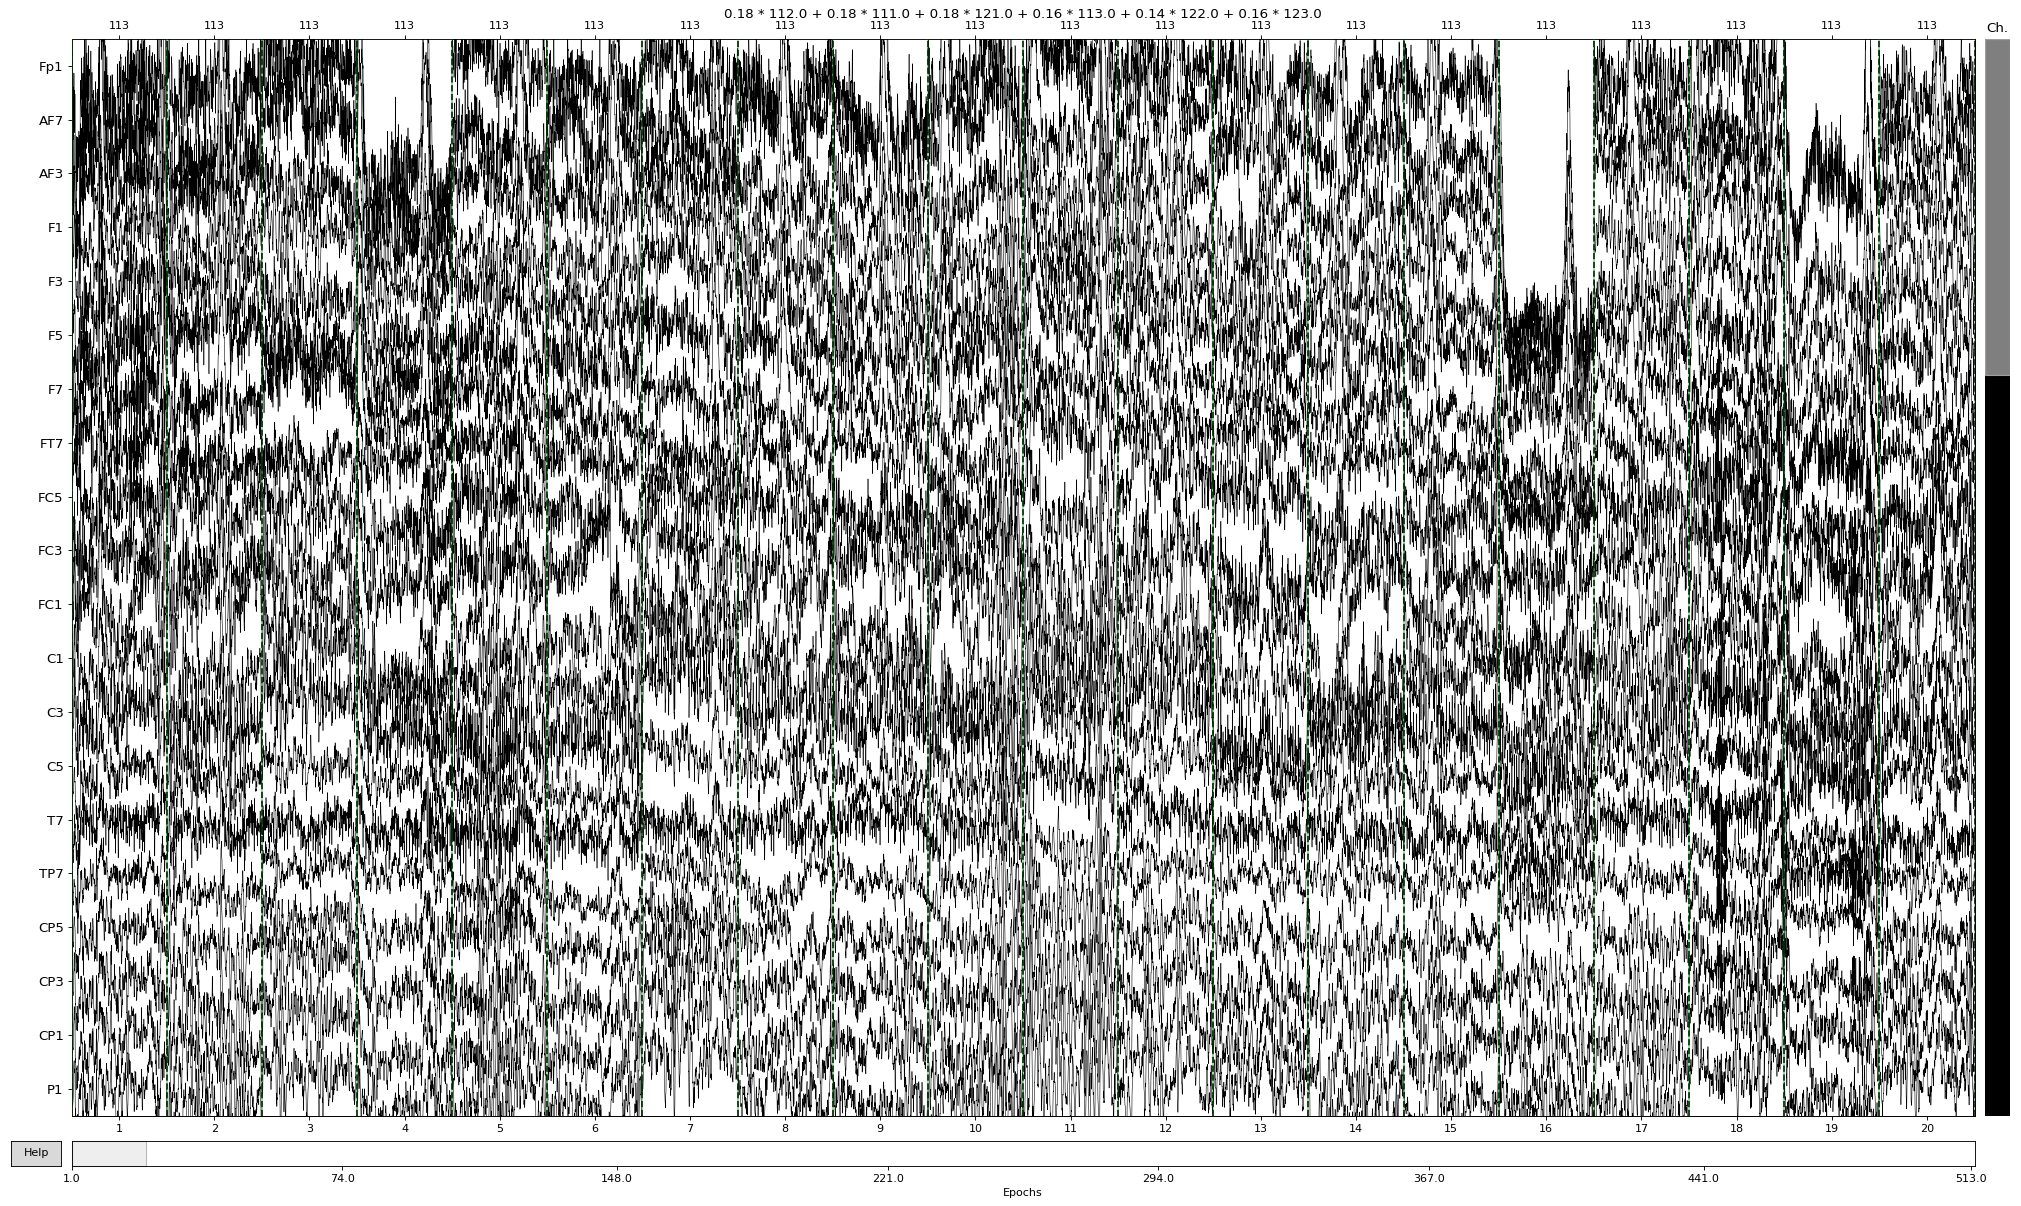

In [250]:
epochs_full.plot()

In [167]:
events[0][31:90]

array([[31744,     0,   113],
       [32768,     0,   113],
       [33792,     0,   113],
       [34816,     0,   113],
       [35840,     0,   113],
       [36864,     0,   113],
       [37888,     0,   113],
       [38912,     0,   113],
       [39936,     0,   113],
       [40960,     0,   113],
       [41984,     0,   113],
       [43008,     0,   113],
       [44032,     0,   113],
       [45056,     0,   113],
       [46080,     0,   113],
       [47104,     0,   113],
       [48128,     0,   113],
       [49152,     0,   113],
       [50176,     0,   113],
       [51200,     0,   113],
       [52224,     0,   113],
       [53248,     0,   113],
       [54272,     0,   113],
       [55296,     0,   113],
       [56320,     0,   113],
       [57344,     0,   113],
       [58368,     0,   113],
       [59392,     0,   113],
       [60416,     0,   113],
       [61440,     0,   113],
       [62464,     0,   113],
       [63488,     0,   113],
       [64512,     0,   113],
       [65

# Below are personalised function -> to py script and import

In [244]:
import warnings

def removeItem_from_dict(d,key):
    r = dict(d)
    del r[key]
    return r

def dict_getValue(dictionary, search_value):
    for key,value in dictionary.items():
        if value==search_value:
            return key

def mne_annotation_empty(annotations):
    index_dlt = 0
    for i in range(annotations.__len__()):
        annotations.delete(i-index_dlt)
        index_dlt+=1
    return annotations

def mne_annotation_postpone (pptime, annotations):
    onset = []
    duration = []
    description = []
    index_dlt = 0
    for i in range(annotations.__len__()):
        onset.append(annotations.__getitem__(i)['onset']+pptime)
        duration.append(0.0)
        description.append(annotations.__getitem__(i)['description'])
    for i in range(annotations.__len__()):
        annotations.delete(i-index_dlt)
        index_dlt+=1
    annotations.append(onset=onset,duration=duration,description=description)
    print ('annotation time shift succeed')
    
        

def mne_annotation_recode_by_adding(section,state,annotations):
    onset = []
    duration = []
    description = []
    for i in range(annotations.__len__()):
        if annotations.__getitem__(i)['description'] in ['131.0','132.0']:
            onset,duration,description = mne_annotation_recode_info_extract(section=section,state=state,
                                                                        original_annotation = 
                                                                        annotations.__getitem__(i),
                                                                       onset=onset,duration=duration,
                                                                        description=description)
        else:
            continue
    index_dlt = 0
    for i in range(annotations.__len__()):
        if annotations.__getitem__(i-index_dlt)['description'] in ['131.0','132.0']:
            annotations.delete(i-index_dlt)
            index_dlt+=1
        else:
            continue
    onset.append(0.0)
    duration.append(0.0)
    description.append(mne_annotation_add_baseline(section=section,state=state))
    annotations.append(onset=onset,duration=duration,description=description)
    print ('annotation engineering succeed')
    return True

def mne_annotation_add_baseline(section,state):
    if section == '1':
        if state == 'VD':
            return '113.0'
        elif state == 'FA':
            return '123.0'
        elif state == 'OP':
            return '133.0'
        else:
            warnings.warn("unknown state detected", DeprecationWarning)
    elif section == '2':
        if state == 'VD':
            return '213.0'
        elif state == 'FA':
            return '223.0'
        elif state == 'OP':
            return '233.0'
        else:
            warnings.warn("unknown state detected", DeprecationWarning)
    else:
        warnings.warn("add baseline function only apply on rawfile having 2 sections", DeprecationWarning)
    return '999.0'
        

def mne_annotation_recode_info_extract(section,state,original_annotation,onset,duration,description):
    if section =='1':
        if state == 'VD':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('111.0')
                
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('112.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'FA':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('121.0')

            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('122.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'OP':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('131.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('132.0')
            else:
                print('this function only detect VD, FA, OP states, please check original annotations')
    elif section =='2':
        if state == 'VD':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('211.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('212.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'FA':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('221.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('222.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'OP':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('231.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('123.0')
            else:
                print('this function only detect VD, FA, OP states, please check original annotations')
    else:
        print('3rd section dected, please check annotations')
    return(onset,duration,description)
        
